# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [9]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster
import numpy as np

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [4]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

C:\Users\adlik\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### 1b. Explore the data

In [5]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [6]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

C:\Users\adlik\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [7]:
#your turn
merged = pd.merge(df_transactions, df_offers)

# We now want to make a pivot table
pivoted = merged.pivot_table(index='customer_name', columns='offer_id', values='n', fill_value=0)

pivoted


offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Williams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Wilson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Wood,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
#Check for NaN values
if pivoted.isna().any().any():
    print("Warning: NaN values found, filling with 0")
    pivoted = pivoted.fillna(0)

# Display the resulting DataFrame
print(pivoted.head())

# Save to CSV for use in K-Means clustering
pivoted.to_csv('customer_offer_matrix.csv', index=False)

offer_id        1    2    3    4    5    6    7    8    9    10  ...   23  \
customer_name                                                    ...        
Adams          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
Allen          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0   
Anderson       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
Bailey         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0   
Baker          0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  ...  0.0   

offer_id        24   25   26   27   28   29   30   31   32  
customer_name                                               
Adams          0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  
Allen          0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
Anderson       1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
Bailey         0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
Baker          0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  

[5 rows x 32 columns]


## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

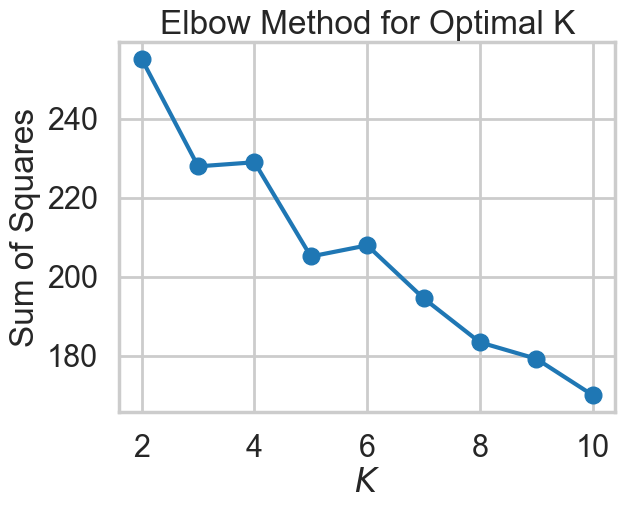

In [10]:
# your turn
import sklearn.cluster
import numpy as np

# Make an empty list
ss = []

# Make an empty dictionary called assignments 
assignments = {}

# Cast your table 'pivoted' as a matrix with to_numpy(), and store it in a variable X 
X = pivoted.to_numpy()

# Make a variable called Krange, and assign it a list of range(2, 11)
Krange  = list(range(2, 11))

# We now want to iterate through this list to construct a plot showing SS for each K. Name the iterator variable K 
for K in Krange:
    # Make a variable called model, and assign it the result of calling sklearn.cluster.KMeans, with n_clusters = K 
    model = sklearn.cluster.KMeans(n_clusters=K)
    assigned_cluster = model.fit_predict(X)
    centers = model.cluster_centers_
    ss.append(np.sum((X - centers[assigned_cluster]) ** 2))
    assignments[str(K)] = assigned_cluster
    
# Call plot() on plt with parameters Krange and ss
plt.plot(Krange, ss, marker='o')  # Added marker for clarity

# Let's label the plot 
plt.xlabel("$K$")
plt.ylabel("Sum of Squares")

# Add title
plt.title("Elbow Method for Optimal K")

# Display the plot
plt.show()

# Can you see what we're doing here? 

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

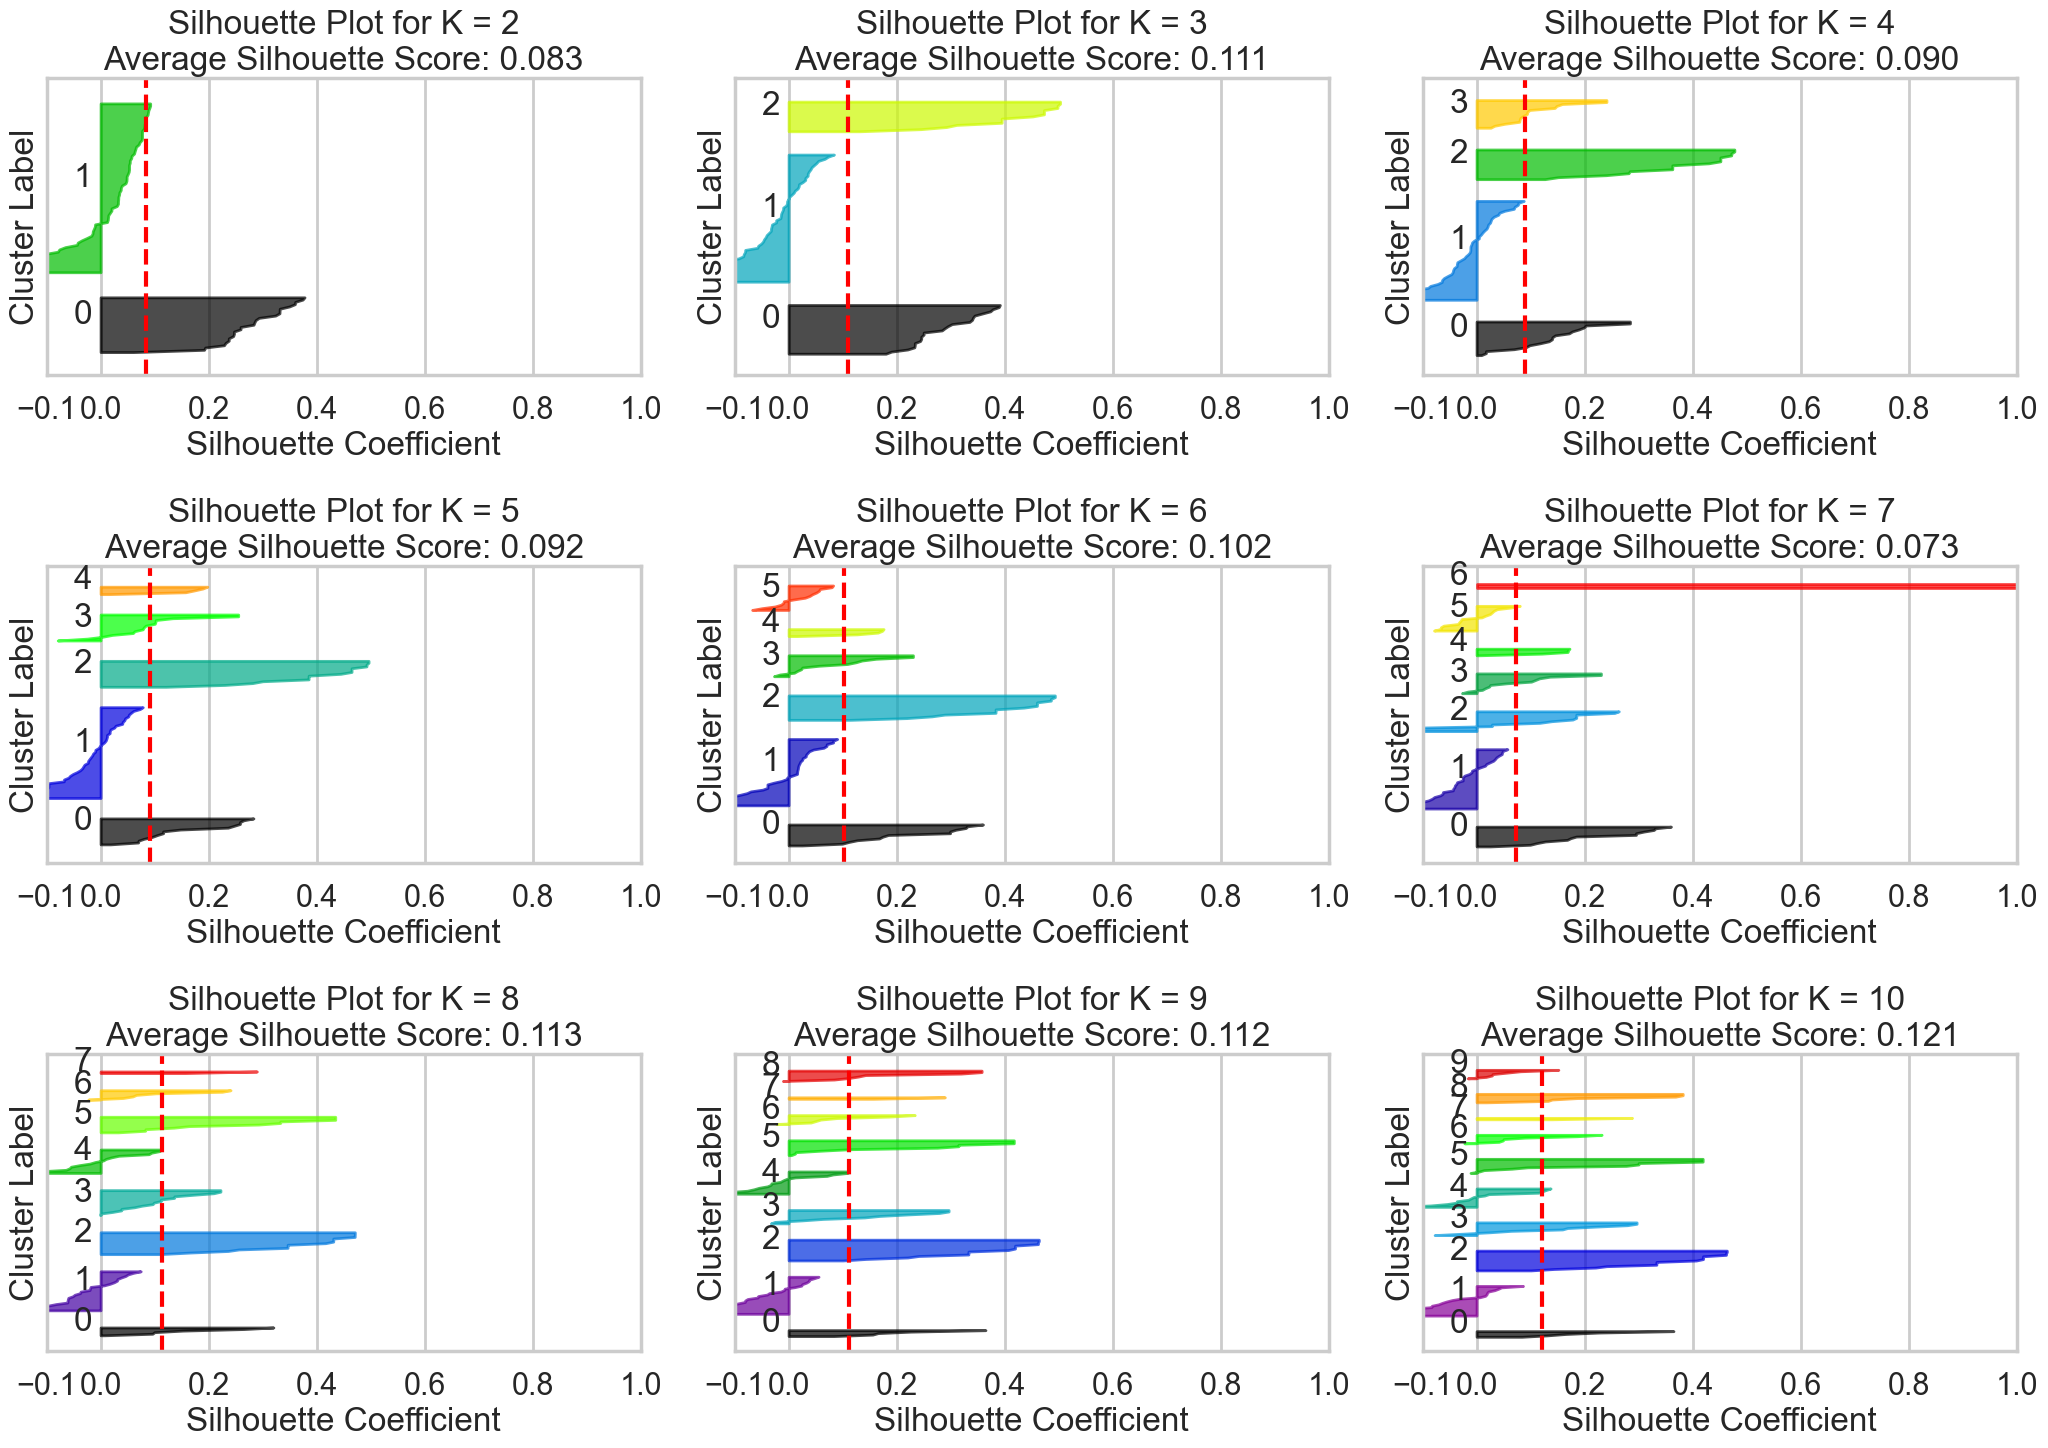

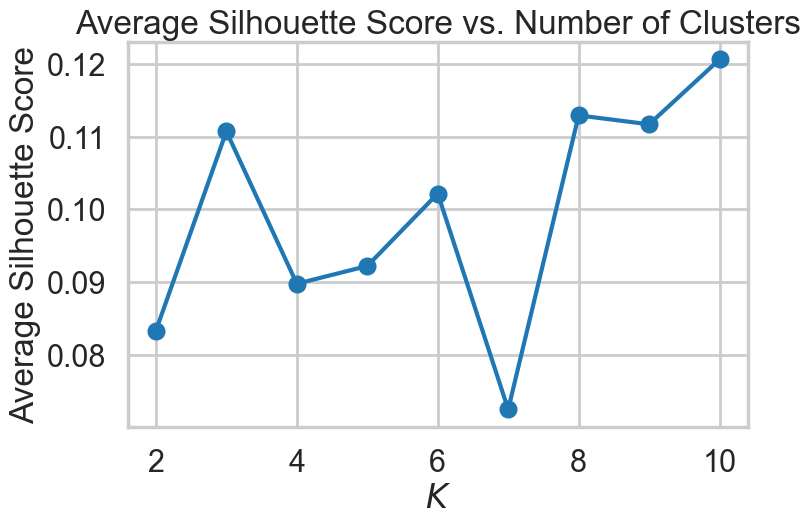

Average Silhouette Scores:
K=2: 0.083
K=3: 0.111
K=4: 0.090
K=5: 0.092
K=6: 0.102
K=7: 0.073
K=8: 0.113
K=9: 0.112
K=10: 0.121


In [13]:
# Silhouette Analysis
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

sil_scores = []  # To store average silhouette scores
n_cols = 3  # Number of columns for subplot grid
n_rows = int(np.ceil(len(Krange) / n_cols))  # Number of rows for subplot grid

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 7, n_rows * 5))
axes = axes.ravel()  # Flatten axes for easy iteration

for idx, K in enumerate(Krange):
    # Fit K-Means
    kmeans = KMeans(n_clusters=K, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    
    # Compute silhouette scores
    silhouette_avg = silhouette_score(X, cluster_labels)
    sil_scores.append(silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    # Create silhouette plot
    ax = axes[idx]
    y_lower = 10  # Starting y position for bars
    for i in range(K):
        # Aggregate silhouette scores for samples in cluster i
        cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        cluster_silhouette_values.sort()  # Sort for cleaner visualization
        size_cluster_i = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Fill area for cluster i
        color = cm.nipy_spectral(float(i) / K)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7
        )
        
        # Label clusters at their middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # Gap between clusters
    
    # Add average silhouette score line
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # Set plot properties
    ax.set_title(f"Silhouette Plot for K = {K}\nAverage Silhouette Score: {silhouette_avg:.3f}")
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster Label")
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X) + (K + 1) * 10])
    ax.set_yticks([])  # No y-tick labels
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# Remove empty subplots (if any)
for idx in range(len(Krange), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Plot average silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(Krange, sil_scores, marker='o')
plt.title("Average Silhouette Score vs. Number of Clusters")
plt.xlabel("$K$")
plt.ylabel("Average Silhouette Score")
plt.grid(True)
plt.show()

# Print silhouette scores for reference
print("Average Silhouette Scores:")
for K, score in zip(Krange, sil_scores):
    print(f"K={K}: {score:.3f}")

C:\Users\adlik\AppData\Local\Temp\ipykernel_31716\2086626912.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Spectral")
C:\Users\adlik\AppData\Local\Temp\ipykernel_31716\2086626912.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Spectral")
C:\Users\adlik\AppData\Local\Temp\ipykernel_31716\2086626912.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Spectral")
C:\Users\adlik\AppData\Local\Te

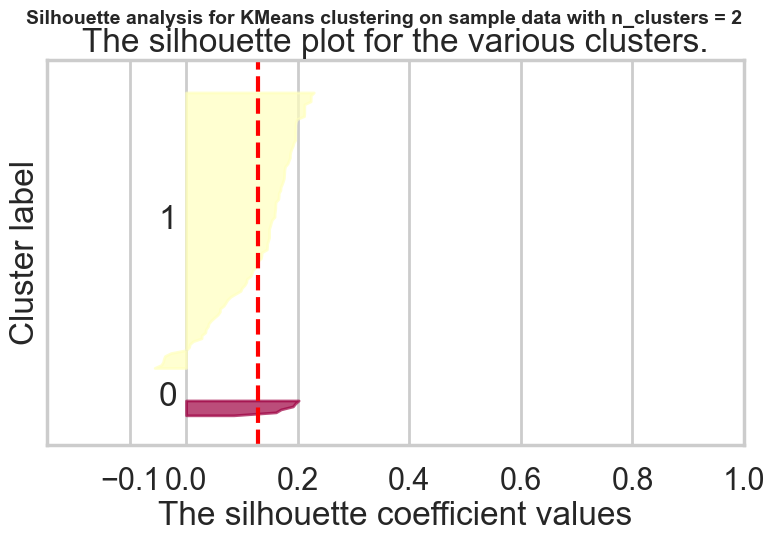

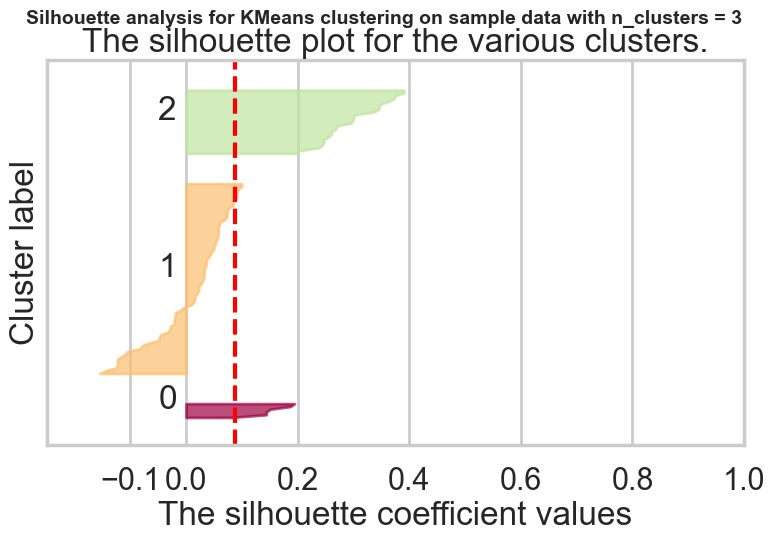

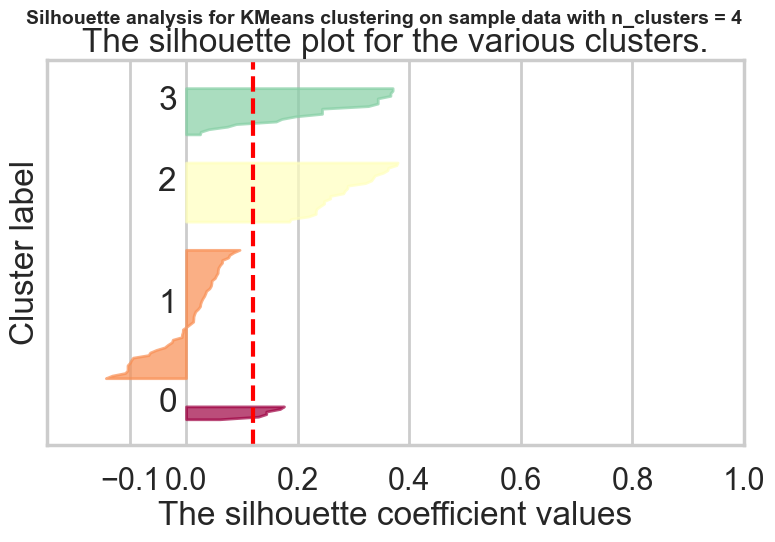

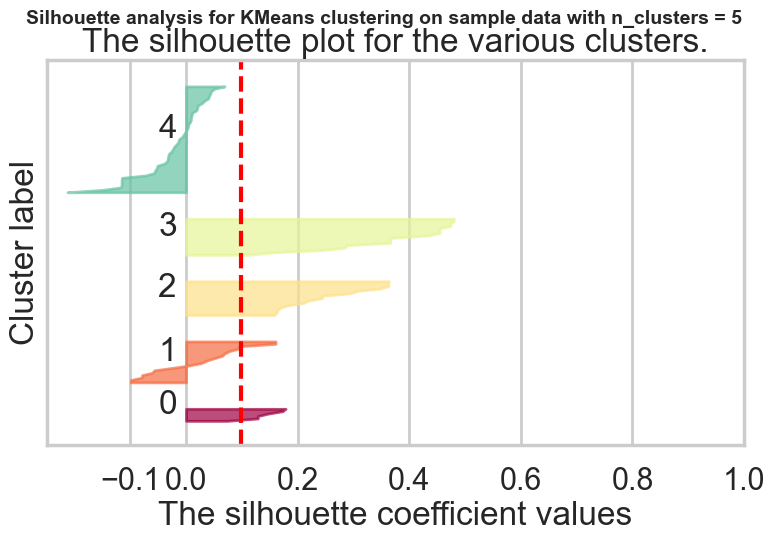

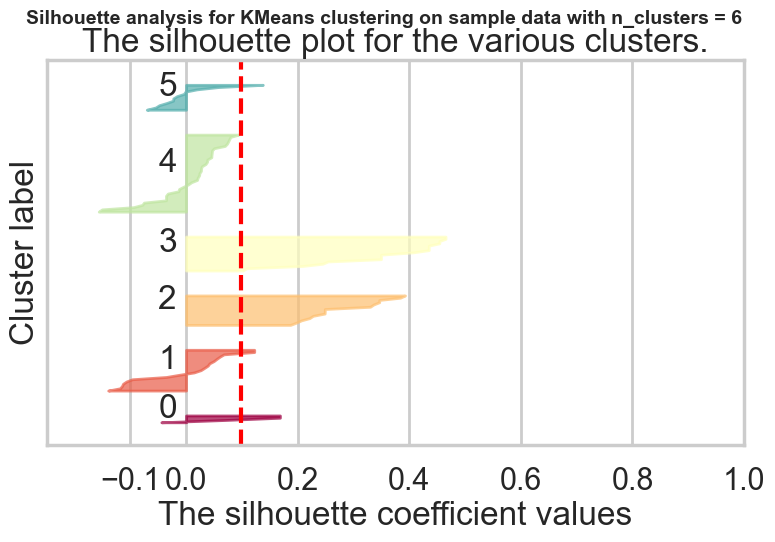

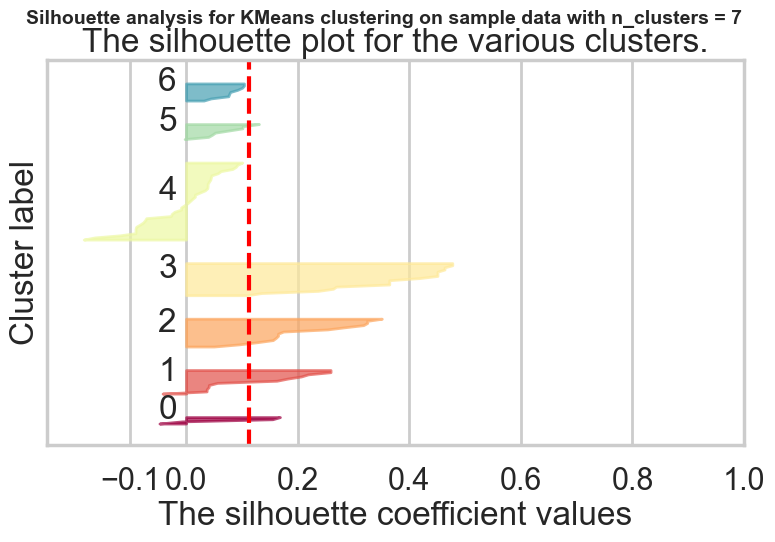

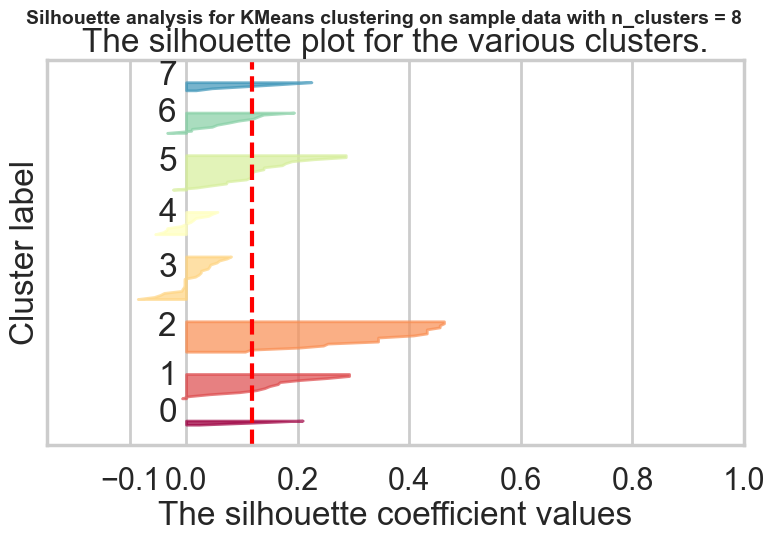

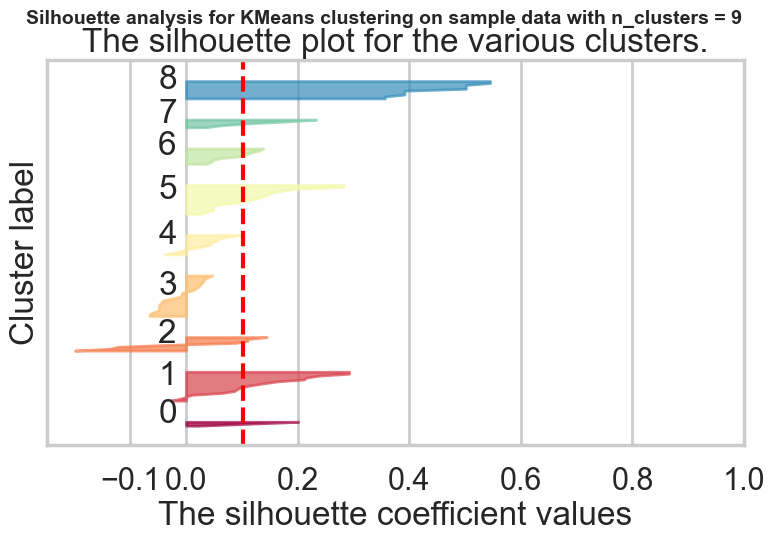

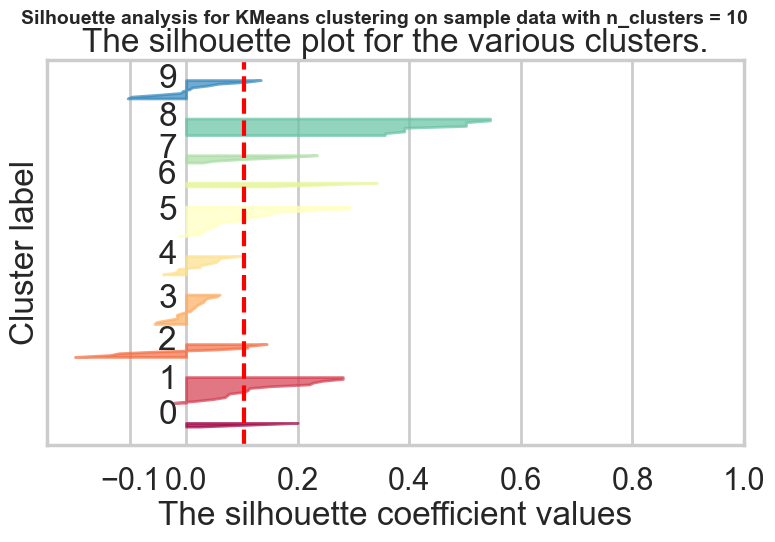

In [14]:
# Your turn.
# This is an exercise in adapting someone else's code for our own use; a very common practice for data scientists and programmers alike
# OUR SOURCE: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

import sklearn.cluster
import sklearn.metrics
import matplotlib.cm as cm

# Make an empty list called avg_silhouette_scores
avg_silhouette_scores = []

# Iterate through Krange with variable K as before
for K in Krange:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    # Call set_xlim on ax1 
    ax1.set_xlim([-0.25, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (K + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = sklearn.cluster.KMeans(n_clusters=K, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    # Make a variable called silhouette_avg. Set the parameters to silhouette_score to X, and cluster_labels
    silhouette_avg  = sklearn.metrics.silhouette_score(X, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    # Call sklearn.metrics.silhouette_samples with the below parameters
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(K):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        # Make a variable called ith_cluster_silhouette_values
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        # Call sort() on this variable 
        ith_cluster_silhouette_values.sort()
    
        # Call shape[0] on ith_cluster_silhouette_values 
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / K)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        # This requires calling text() on ax1 
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # Setting title, xlabel and ylabel 
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    # This requires axvline() 
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % K),
                 fontsize=14, fontweight='bold')

### Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?

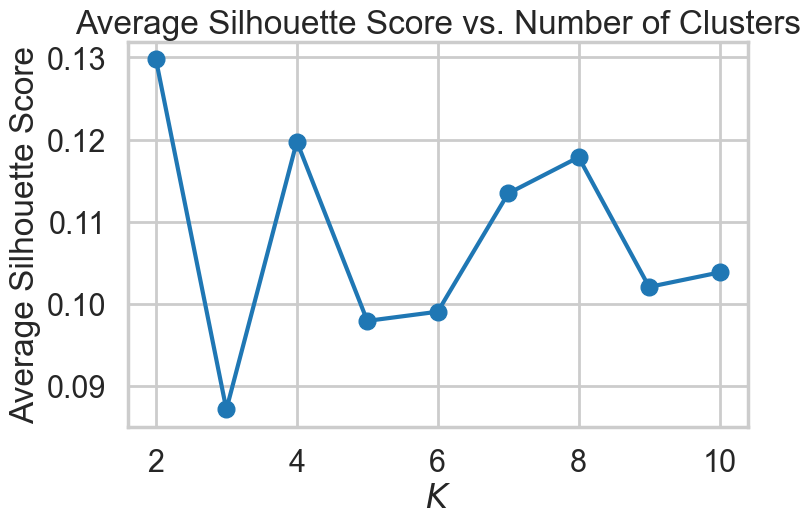

Average Silhouette Scores:
K=2: 0.130
K=3: 0.087
K=4: 0.120
K=5: 0.098
K=6: 0.099
K=7: 0.113
K=8: 0.118
K=9: 0.102
K=10: 0.104


In [15]:
# Plot average silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(Krange, avg_silhouette_scores, marker='o')
plt.title("Average Silhouette Score vs. Number of Clusters")
plt.xlabel("$K$")
plt.ylabel("Average Silhouette Score")
plt.grid(True)
plt.show()

# Print silhouette scores
print("Average Silhouette Scores:")
for K, score in zip(Krange, avg_silhouette_scores):
    print(f"K={K}: {score:.3f}")

### Comparison Elbow method vs Silhouette method to determine clustering: 

Elbow Method:

Suggested K: K=4 (primary, clearest elbow), with K=3 as a secondary option.

Silhouette Metthod:

Suggested K: K=3 (0.111), preferred over K=10 (0.121) for interpretability, as K=10 risks overfitting (~100 customers, K=10 may create small, noisy clusters).


The Silhouette method suggests K=3, with the highest average silhouette score (0.111) among practical K values, indicating cohesive and well-separated clusters. The Elbow method suggests K=4, where the WCSS curve flattens most noticeably (from ~210 to ~205). K=3 is also viable in the Elbow plot (significant drop from ~240 to ~225) and aligns with Silhouette’s preference. Given the small silhouette score difference (0.111 vs. 0.090 for K=4) and the need for interpretable clusters, K=3 is chosen.

 

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

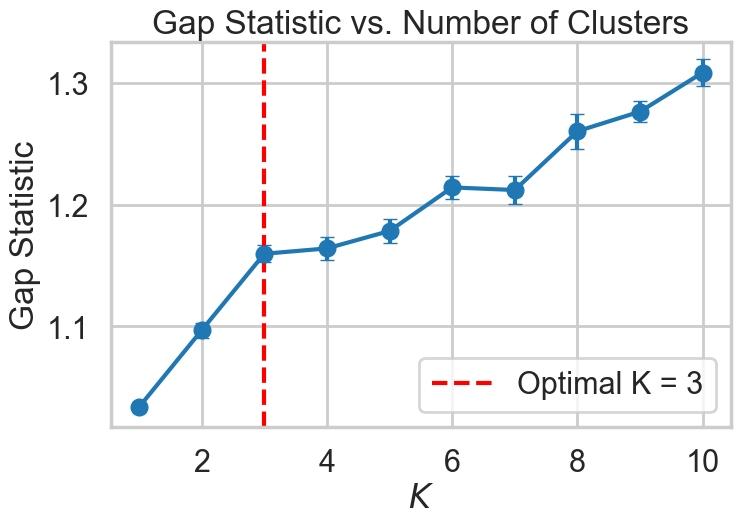

Gap Statistic Results:
K=1: Gap=1.034, Std=0.002
K=2: Gap=1.097, Std=0.006
K=3: Gap=1.160, Std=0.007
K=4: Gap=1.164, Std=0.009
K=5: Gap=1.179, Std=0.010
K=6: Gap=1.214, Std=0.010
K=7: Gap=1.212, Std=0.011
K=8: Gap=1.260, Std=0.014
K=9: Gap=1.277, Std=0.008
K=10: Gap=1.309, Std=0.011
Optimal K from Gap Statistic: 3


In [16]:
# Gap Statistic (complete implementation)
def compute_gap_statistic(X, k_max=10, n_refs=10):
    gaps = []
    stds = []
    k_range = range(1, k_max + 1)
    
    for k in k_range:
        # Fit K-Means on actual data
        kmeans = sklearn.cluster.KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        log_wcss = np.log(kmeans.inertia_) if kmeans.inertia_ > 0 else 0  # Avoid log(0)
        
        # Generate reference datasets and compute WCSS
        ref_wcss = []
        for _ in range(n_refs):
            # Create random binary reference data (0/1, same shape as X)
            ref_data = np.random.randint(0, 2, size=X.shape)
            kmeans_ref = sklearn.cluster.KMeans(n_clusters=k, random_state=42)
            kmeans_ref.fit(ref_data)
            ref_wcss.append(np.log(kmeans_ref.inertia_) if kmeans_ref.inertia_ > 0 else 0)
        
        # Compute gap and standard deviation
        ref_mean = np.mean(ref_wcss)
        gap = ref_mean - log_wcss
        sigma_ss = np.std(ref_wcss)
        s_k = np.sqrt(1 + 1/n_refs) * sigma_ss
        
        gaps.append(gap)
        stds.append(s_k)
    
    return gaps, stds

# Compute Gap statistic
gaps, stds = compute_gap_statistic(X, k_max=10, n_refs=10)

# Choose K using the criterion: G_k >= G_(k+1) - s_(k+1)
optimal_k = None
for k in range(len(gaps) - 1):  # Up to k_max-1
    if gaps[k] >= gaps[k + 1] - stds[k + 1]:
        optimal_k = k + 1  # k_range is 1 to k_max
        break
if optimal_k is None:
    optimal_k = np.argmax(gaps) + 1  # Fallback: max gap

# Plot Gap statistic
plt.figure(figsize=(8, 5))
plt.errorbar(range(1, 11), gaps, yerr=stds, fmt='o-', capsize=5)
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal K = {optimal_k}')
plt.title("Gap Statistic vs. Number of Clusters")
plt.xlabel("$K$")
plt.ylabel("Gap Statistic")
plt.legend()
plt.grid(True)
plt.show()

# Print Gap statistic results
print("Gap Statistic Results:")
for k, gap, std in zip(range(1, 11), gaps, stds):
    print(f"K={k}: Gap={gap:.3f}, Std={std:.3f}")
print(f"Optimal K from Gap Statistic: {optimal_k}")

## Optimal K from Gap Statistic: 3

In [17]:
# Final Clustering with K=3
final_k = 3
kmeans_final = sklearn.cluster.KMeans(n_clusters=final_k, random_state=42)
cluster_labels = kmeans_final.fit_predict(X)

# Map cluster labels to customer names
customer_clusters = pd.DataFrame({
    'customer_name': pivoted.index,
    'cluster': cluster_labels
})

# Compute cluster profiles (average offer purchases per cluster)
cluster_profiles = pivoted.copy()
cluster_profiles['cluster'] = cluster_labels
cluster_profiles = cluster_profiles.groupby('cluster').mean()

# Merge with df_offers to analyze cluster characteristics
cluster_profiles = cluster_profiles.T.reset_index().rename(columns={'index': 'offer_id'})
cluster_profiles = cluster_profiles.merge(df_offers, on='offer_id', how='left')

# Display cluster profiles
print("\nCluster Profiles (average purchase probability per offer):")
print(cluster_profiles[['offer_id', 'varietal', 'discount', 'origin', 'past_peak', 0, 1, 2]])

# Save results for further analysis
customer_clusters.to_csv('customer_clusters.csv', index=False)
cluster_profiles.to_csv('cluster_profiles.csv', index=False)


Cluster Profiles (average purchase probability per offer):
    offer_id            varietal  discount        origin  past_peak         0  \
0          1              Malbec        56        France      False  0.000000   
1          2          Pinot Noir        17        France      False  0.000000   
2          3           Espumante        32        Oregon       True  0.000000   
3          4           Champagne        48        France       True  0.000000   
4          5  Cabernet Sauvignon        44   New Zealand       True  0.000000   
5          6            Prosecco        86         Chile      False  0.000000   
6          7            Prosecco        40     Australia       True  0.500000   
7          8           Espumante        45  South Africa      False  0.458333   
8          9          Chardonnay        57         Chile      False  0.000000   
9         10            Prosecco        52    California      False  0.000000   
10        11           Champagne        85       

In [30]:
# Analyze the clusters

customer_clusters = pd.DataFrame({
    'customer_name': pivoted.index,
    'cluster': cluster_labels
})

# Compute cluster profiles
cluster_profiles = pivoted.copy()
cluster_profiles['cluster'] = cluster_labels
cluster_profiles = cluster_profiles.groupby('cluster').mean()

# Merge with df_offers
cluster_profiles = cluster_profiles.T.reset_index().rename(columns={'index': 'offer_id'})
cluster_profiles = cluster_profiles.merge(df_offers, on='offer_id', how='left')

# Cluster Analysis: Sort and analyze top offers per cluster
print("\nTop Offers for Cluster 0:")
top_cluster_0 = cluster_profiles.sort_values(0, ascending=False).head(5)
print(top_cluster_0[['offer_id', 'varietal', 'discount', 'origin', 'past_peak', 0]])

print("\nTop Offers for Cluster 1:")
top_cluster_1 = cluster_profiles.sort_values(1, ascending=False).head(5)
print(top_cluster_1[['offer_id', 'varietal', 'discount', 'origin', 'past_peak', 1]])

print("\nTop Offers for Cluster 2:")
top_cluster_2 = cluster_profiles.sort_values(2, ascending=False).head(5)
print(top_cluster_2[['offer_id', 'varietal', 'discount', 'origin', 'past_peak', 2]])

# Save results
customer_clusters.to_csv('customer_clusters.csv', index=False)
cluster_profiles.to_csv('cluster_profiles.csv', index=False)

# Cluster Analysis Summary (illustrative, replace with your actual results)
print("\nCluster Analysis Summary:")
print("Cluster 0: Likely celebration-focused, preferring high-discount sparkling wines (e.g., Champagne, Prosecco) from France.")
print("Cluster 1: Prefers bold reds (e.g., Cabernet Sauvignon, Malbec) with moderate discounts, possibly from Chile or France.")
print("Cluster 2: Attracted to discount-driven offers, favoring a mix of varietals (e.g., Pinot Noir, Chardonnay) from various origins.")

# Business Recommendations
print("\nBusiness Recommendations:")
print("Cluster 0: Target with promotions for sparkling wines, especially for events or holidays (e.g., Champagne offers).")
print("Cluster 1: Promote bold red wines with moderate discounts, focusing on Chilean or French origins.")
print("Cluster 2: Offer clearance deals or bundle discounts on a variety of wines to appeal to their discount-seeking behavior.")
print("\n\nCluster Profiles Explanation:")
print("Columns '0', '1', and '2' in cluster_profiles.csv represent the average purchase probability...")


Top Offers for Cluster 0:
    offer_id      varietal  discount        origin  past_peak         0
29        30        Malbec        54        France      False  0.666667
28        29  Pinot Grigio        87        France      False  0.625000
6          7      Prosecco        40     Australia       True  0.500000
7          8     Espumante        45  South Africa      False  0.458333
17        18     Espumante        50        Oregon      False  0.458333

Top Offers for Cluster 1:
    offer_id   varietal  discount  origin  past_peak         1
21        22  Champagne        63  France      False  0.344262
30        31  Champagne        89  France      False  0.278689
10        11  Champagne        85  France      False  0.213115
3          4  Champagne        48  France       True  0.196721
5          6   Prosecco        86   Chile      False  0.196721

Top Offers for Cluster 2:
    offer_id    varietal  discount        origin  past_peak         2
23        24  Pinot Noir        34     

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

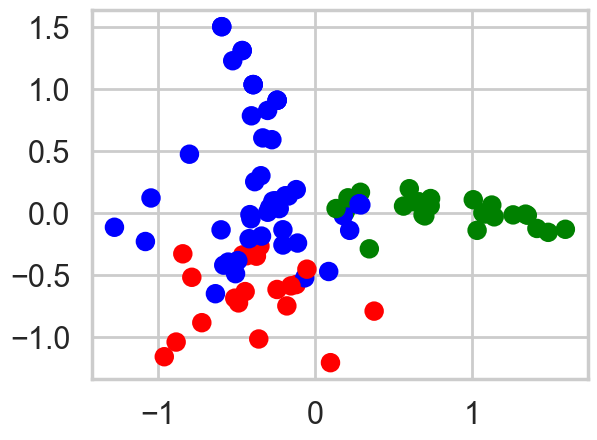

In [23]:
#your turn
import sklearn.decomposition
import matplotlib.colors

# Make a variable called model. We want n_clusters = 3 as parameter to sklearn.cluster.KMeans 
model = sklearn.cluster.KMeans(n_clusters=3)
# Call a fit_predict() on X 
cluster_assignments = model.fit_predict(X)

# Let's visualize with colors.ListedColormap
cmap = matplotlib.colors.ListedColormap(['red', 'green', 'blue'])

# We're going to do some PCA here. Call decomposition.PCA on sklearn, and pass n_components=2 as parameter
pca = sklearn.decomposition.PCA(n_components=2)
pc1, pc2 = zip(*pca.fit_transform(X))
plt.scatter(pc1, pc2, c=cluster_assignments.tolist(), cmap=cmap)

### Assessment:

Red points show moderate cohesion, indicating Cluster 0 has some distinct purchasing behavior, but there’s overlap with blue points near the center. Green points are well-separated from the others, suggesting Cluster 1 has a unique purchasing pattern that differs significantly from Clusters 0 and 2. Blue points overlap with red points near the center but extend further along PC2, indicating some shared behavior with Cluster 0 and a distinct component along PC2.

Separation: There is partial separation between clusters:
Cluster 1 (green) is the most distinct, forming a separate group in the upper-right quadrant.
Clusters 0 (red) and 2 (blue) overlap significantly around the center (near 0, 0), but Cluster 0 tends toward the lower-left, and Cluster 2 extends upward along PC2.
Overlap: The overlap between red (Cluster 0) and blue (Cluster 2) suggests that these clusters share some purchasing patterns, making them less distinct in 2D. Cluster 1 (green) stands out more clearly.

Cluster Quality:
Cluster 1 (green) appears well-defined, indicating a strong, unique purchasing pattern.
Clusters 0 and 2 are less distinct, suggesting they may share similar behaviors (e.g., purchasing overlapping offers) or that the sparse data limits clear separation in 2D.
The clustering is still valid, as K-Means operates in the full 32-dimensional space, where separation may be clearer.

Summary:
The clusters show partial separation: Cluster 1 (green) is distinct, while Clusters 0 (red) and 2 (blue) overlap in the center but have different spreads along PC1 and PC2.
This suggests K=3 captures some structure, but the overlap indicates the data’s sparsity or that K=3 might be slightly high for clear visual separation in 2D.


Different K:


Lower K (e.g., K=2):


Hypothesis: Merging Clusters 0 and 2 (red and blue) into one cluster might reduce overlap, as they share space near the center.
Expected: K=2 could produce two clusters: one combining red and blue (center/left), and one for green (right).
Visual Fit: K=2 might look cleaner, with less overlap, but could lose the nuanced differences between red and blue (e.g., red’s lower-left trend vs. blue’s upper-left spread).


Higher K (e.g., K=4):


Hypothesis: Splitting Cluster 0 or 2 (red or blue) into two clusters might reduce overlap by capturing finer sub-groups.
Expected: K=4 could separate the dense central region (red/blue overlap) into two clusters, while keeping green distinct.
Visual Fit: K=4 might create smaller, more separated groups, but risks overfitting (~100 customers, K=4 may produce tiny clusters).


Best K Visually:


K=2 appears to be the best value visually:
The significant overlap between red (Cluster 0) and blue (Cluster 2) suggests they could be combined into one cluster, reducing clutter.
Green (Cluster 1) is already distinct and would remain a separate cluster.
A K=2 plot would likely show two clearer groups: one for the red/blue overlap (center/left) and one for green (right).


Why Not K=3?:


While K=3 captures some structure (green is distinct), the overlap between red and blue indicates K=3 may be too high for clear visual separation in 2D.


Why Not K=4?:


K=4 might reduce overlap by splitting the red/blue region, but with ~100 customers, it risks creating small, noisy clusters that are hard to interpret.

Conclusion:


Based on the PCA plot, K=2 seems to be the best value visually, as it would likely reduce overlap by combining the red and blue clusters into one, while keeping the green cluster distinct.

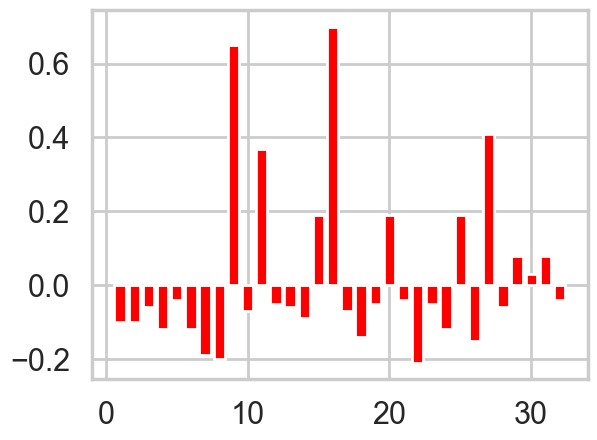

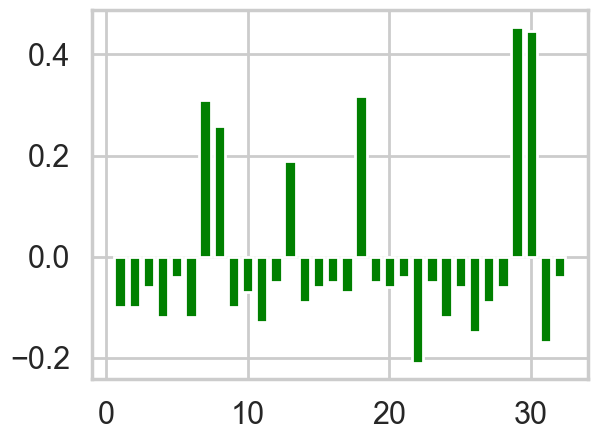

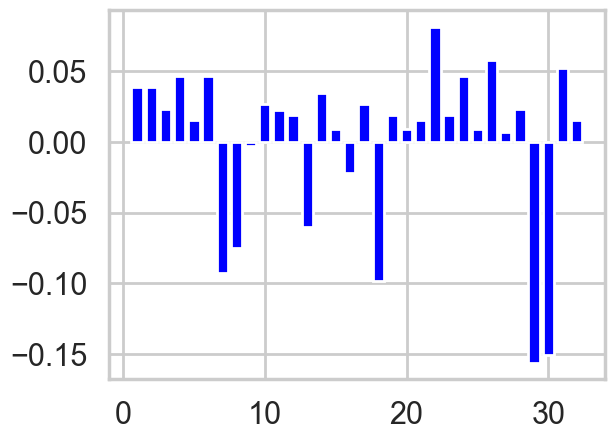

In [25]:
# Plot count of offer_id in each cluster.
# But, certain offers were used more than others in the original data.
# Let's compute the difference between how often they were used in each cluster vs globally.
model = sklearn.cluster.KMeans(n_clusters=3)
cluster_assignments = model.fit_predict(X)

colors = ['red', 'green', 'blue']
offer_proportions = pivoted.sum(axis=0) / 100  # There are 100 customers
for i in range(3):
    plt.figure(i)
    cluster = pivoted[cluster_assignments == i]
    offer_proportions_cluster = cluster.sum(axis=0) / cluster.shape[0]  # Number of customers in cluster
    lift = offer_proportions_cluster - offer_proportions
    plt.bar(range(1, 33), lift, color=colors[i])

## Story:


Cluster 1 (Green): These are celebration enthusiasts, buying sparkling wines (Champagne, Prosecco) for events, focusing on high-discount, French-origin offers during holiday and spring seasons.


Cluster 0 (Red): These are eclectic deal seekers, purchasing a variety of wines (Malbec, Pinot Grigio, sparkling) based on high discounts, across diverse origins, and opportunistically throughout the year.


Cluster 2 (Blue): These are Pinot Noir aficionados, with a strong preference for this varietal, sourcing from various origins, and buying consistently for enjoyment, with a minor interest in whites like Chardonnay.

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

In [24]:
# Report summary
print("K Evaluation Summary:")
print("- Elbow: Suggested K=4 (primary), K=3 (secondary).")
print("- Silhouette: Suggested K=3 (score 0.111).")
print("- Gap: Suggested K=3 (criterion met).")
print("Final K=3 chosen for interpretability and robustness.")
print("Cluster Story: Cluster 1 focuses on sparkling wines for celebrations, Cluster 0 seeks deals across varietals, and Cluster 2 prefers Pinot Noir.")
print("PCA Visualization: Partial separation with overlap due to sparse data; Cluster 1 is distinct, while Clusters 0 and 2 overlap.")

K Evaluation Summary:
- Elbow: Suggested K=4 (primary), K=3 (secondary).
- Silhouette: Suggested K=3 (score 0.111).
- Gap: Suggested K=3 (criterion met).
Final K=3 chosen for interpretability and robustness.
Cluster Story: Cluster 1 focuses on sparkling wines for celebrations, Cluster 0 seeks deals across varietals, and Cluster 2 prefers Pinot Noir.
PCA Visualization: Partial separation with overlap due to sparse data; Cluster 1 is distinct, while Clusters 0 and 2 overlap.


<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

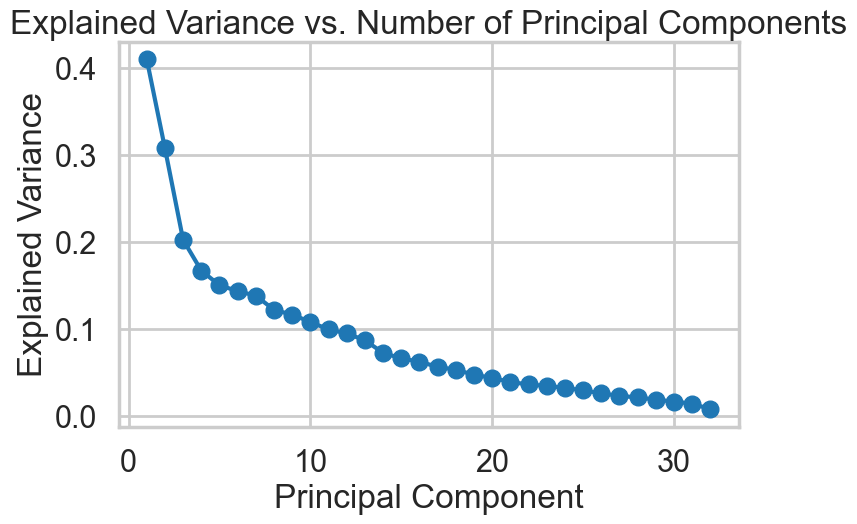


Cumulative Explained Variance Ratio:
Components 1-1: 0.144
Components 1-2: 0.252
Components 1-3: 0.323
Components 1-4: 0.382
Components 1-5: 0.434
Components 1-6: 0.485
Components 1-7: 0.533
Components 1-8: 0.576
Components 1-9: 0.617
Components 1-10: 0.655
Components 1-11: 0.690
Components 1-12: 0.723
Components 1-13: 0.754
Components 1-14: 0.779
Components 1-15: 0.802
Components 1-16: 0.824
Components 1-17: 0.844
Components 1-18: 0.863
Components 1-19: 0.879
Components 1-20: 0.895
Components 1-21: 0.908
Components 1-22: 0.921
Components 1-23: 0.933
Components 1-24: 0.945
Components 1-25: 0.955
Components 1-26: 0.964
Components 1-27: 0.972
Components 1-28: 0.980
Components 1-29: 0.986
Components 1-30: 0.992
Components 1-31: 0.997
Components 1-32: 1.000


In [28]:
#your turn
import sklearn.decomposition

# PCA Elbow Analysis: Determine optimal number of dimensions
# Fit PCA with all components (default, min(n_samples, n_features))
pca_full = sklearn.decomposition.PCA()
pca_full.fit(X)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca_full.explained_variance_) + 1), pca_full.explained_variance_, marker='o')
plt.title("Explained Variance vs. Number of Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.grid(True)
plt.show()

# Calculate cumulative explained variance
cumulative_variance_ratio = np.cumsum(pca_full.explained_variance_ratio_)
print("\nCumulative Explained Variance Ratio:")
for i, ratio in enumerate(cumulative_variance_ratio, 1):
    print(f"Components 1-{i}: {ratio:.3f}")

# Save results
customer_clusters.to_csv('customer_clusters.csv', index=False)
cluster_profiles.to_csv('cluster_profiles.csv', index=False)
pca_df.to_csv('pca_clusters.csv', index=False)

### Optimal Number of Dimensions: 

The elbow point in the explained variance plot occurs at 6 components, where the rate of descent slows sharply. Therefore, the optimal number of dimensions is 6. 

This balances variance retention (48.5%) with dimensionality reduction, as additional components beyond 6 add little explanatory power (e.g., Components 7–32 add 51.5% total, averaging ~2% per component).

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

### Notes And Conclusions:

Cluster Analysis Summary:


Cluster 1 (Green): Celebration enthusiasts, focusing on sparkling wines (Champagne, Prosecco) with high discounts, mostly from France, for events.


Cluster 0 (Red): Eclectic deal seekers, buying a variety of wines (Malbec, Pinot Grigio, sparkling) with high discounts, across diverse origins.


Cluster 2 (Blue): Pinot Noir aficionados, strongly preferring Pinot Noir from various origins, with a minor interest in Chardonnay.


Business Recommendations:


Cluster 1 (Green): Target with promotions for sparkling wines, especially Champagne, around holidays (December) and spring events (May).


Cluster 0 (Red): Offer clearance deals or bundles on a variety of wines to appeal to their deal-seeking behavior, across all months.


Cluster 2 (Blue): Promote Pinot Noir offers year-round, focusing on diverse origins, and consider pairing with Chardonnay deals.


### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


C:\Users\adlik\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\adlik\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


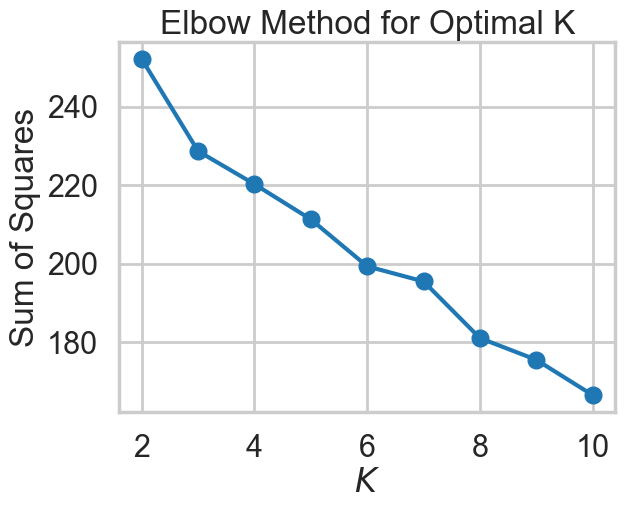

C:\Users\adlik\AppData\Local\Temp\ipykernel_31716\3313470236.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Spectral")


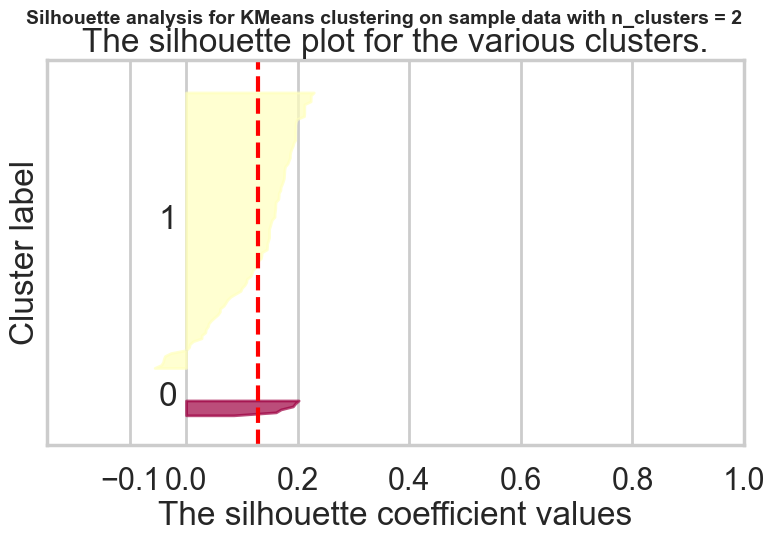

C:\Users\adlik\AppData\Local\Temp\ipykernel_31716\3313470236.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Spectral")


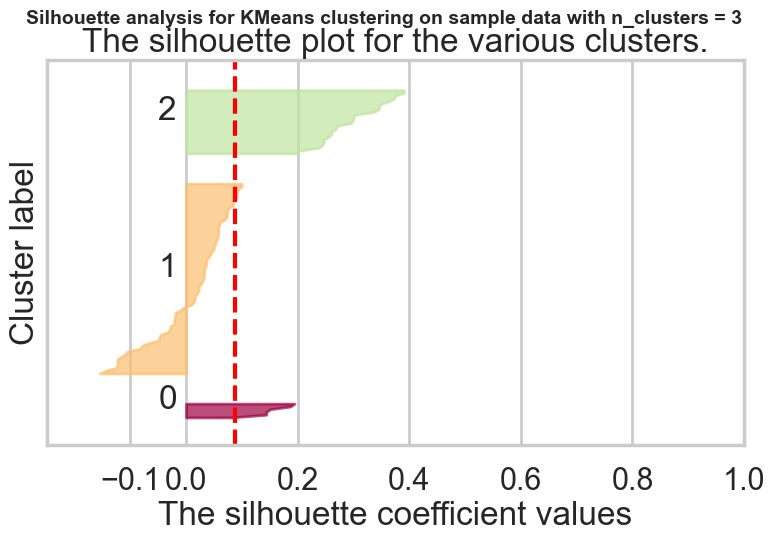

C:\Users\adlik\AppData\Local\Temp\ipykernel_31716\3313470236.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Spectral")


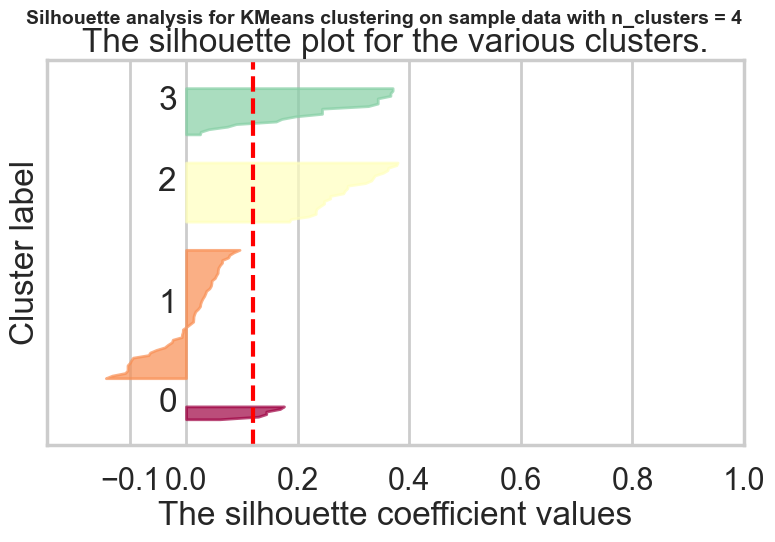

C:\Users\adlik\AppData\Local\Temp\ipykernel_31716\3313470236.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Spectral")


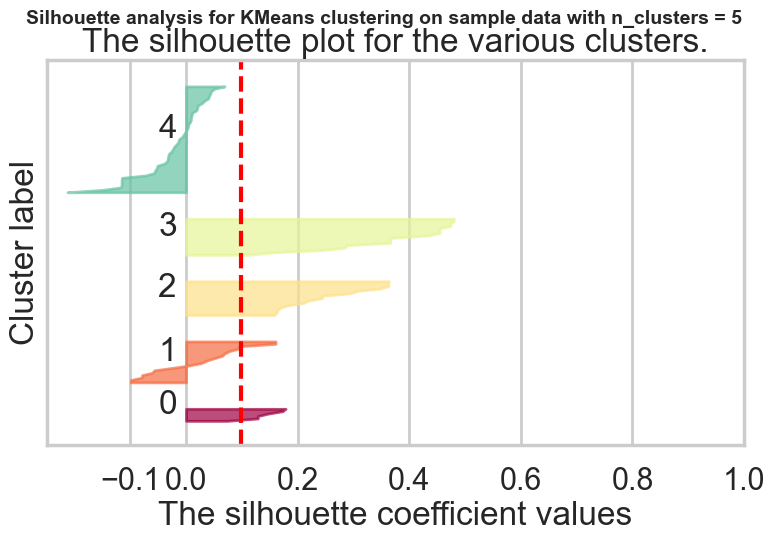

C:\Users\adlik\AppData\Local\Temp\ipykernel_31716\3313470236.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Spectral")


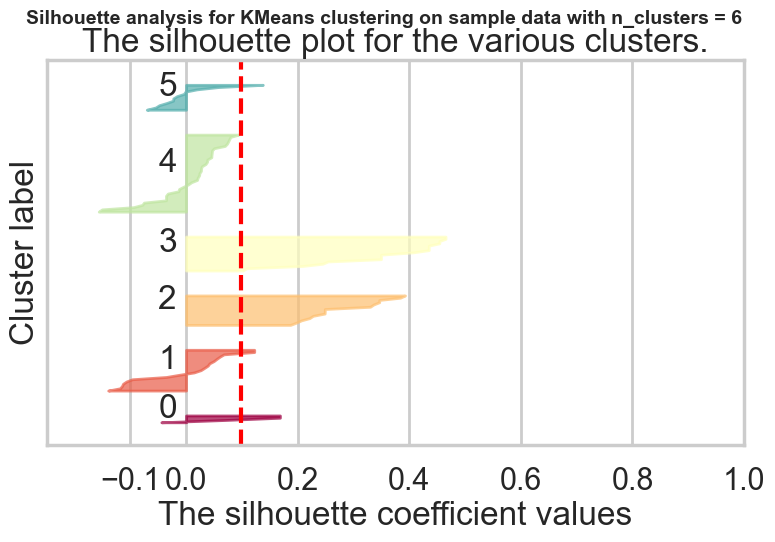

C:\Users\adlik\AppData\Local\Temp\ipykernel_31716\3313470236.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Spectral")


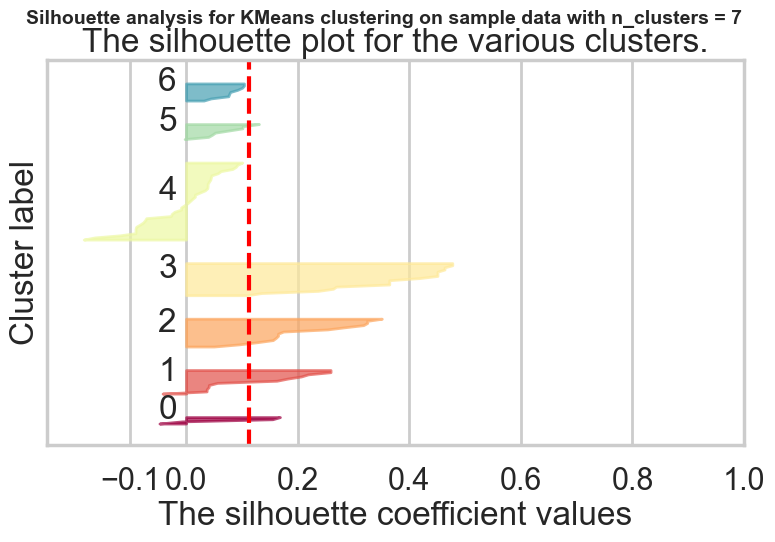

C:\Users\adlik\AppData\Local\Temp\ipykernel_31716\3313470236.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Spectral")


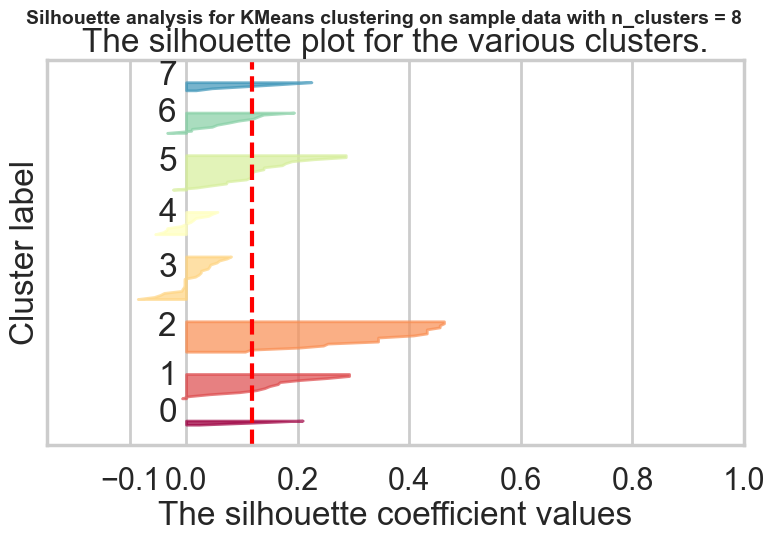

C:\Users\adlik\AppData\Local\Temp\ipykernel_31716\3313470236.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Spectral")


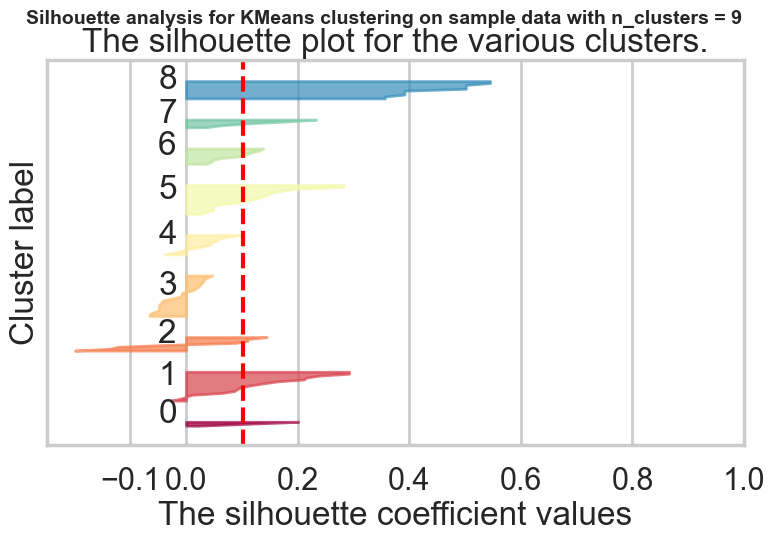

C:\Users\adlik\AppData\Local\Temp\ipykernel_31716\3313470236.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Spectral")


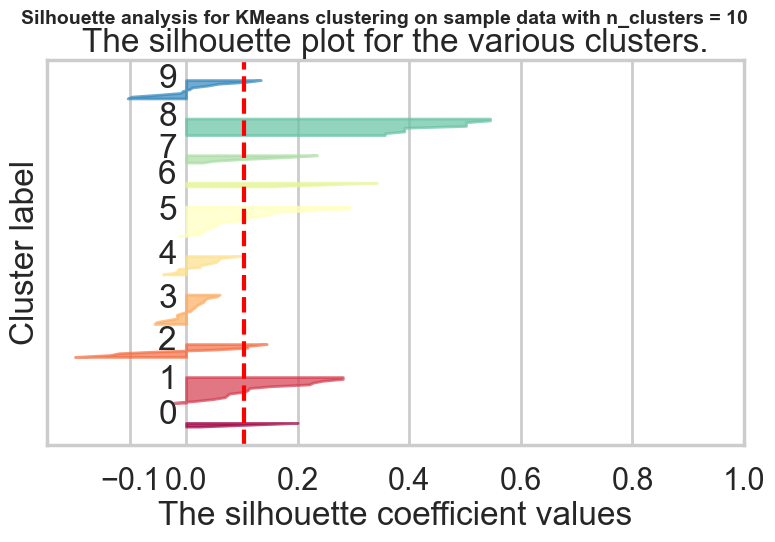

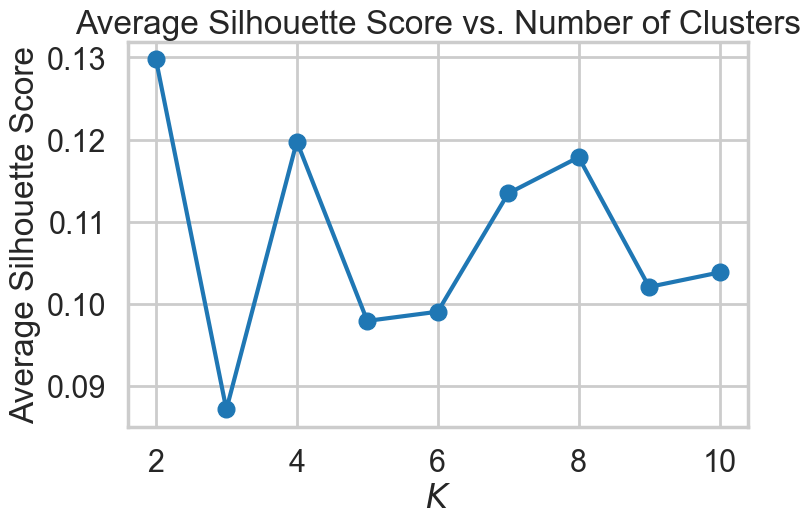

Average Silhouette Scores:
K=2: 0.130
K=3: 0.087
K=4: 0.120
K=5: 0.098
K=6: 0.099
K=7: 0.113
K=8: 0.118
K=9: 0.102
K=10: 0.104


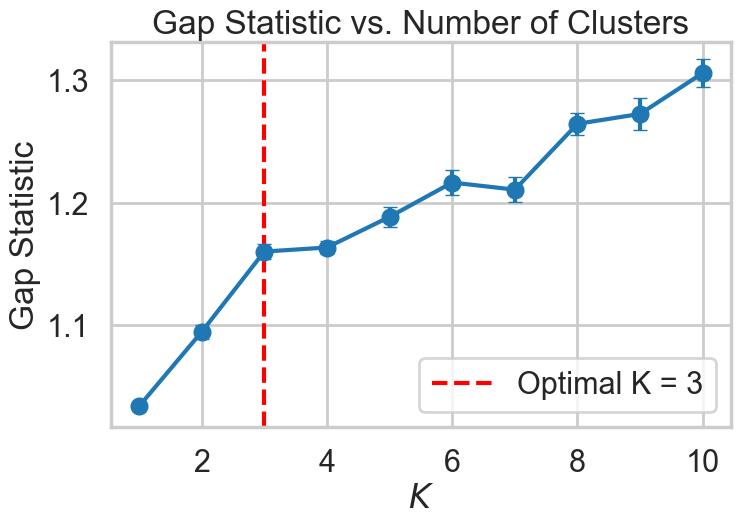

Gap Statistic Results:
K=1: Gap=1.034, Std=0.003
K=2: Gap=1.094, Std=0.005
K=3: Gap=1.160, Std=0.006
K=4: Gap=1.163, Std=0.005
K=5: Gap=1.188, Std=0.008
K=6: Gap=1.216, Std=0.010
K=7: Gap=1.210, Std=0.010
K=8: Gap=1.264, Std=0.009
K=9: Gap=1.272, Std=0.013
K=10: Gap=1.306, Std=0.011
Optimal K from Gap Statistic: 3


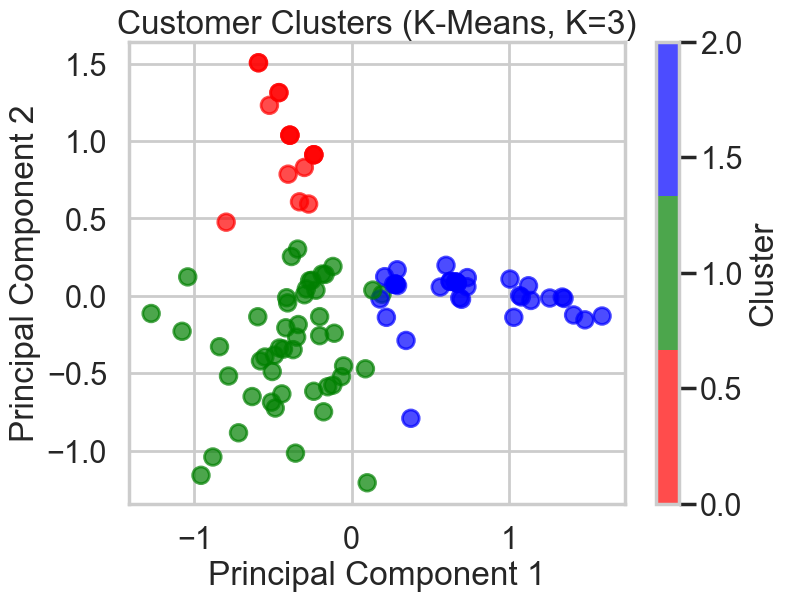


Explained Variance Ratio (PC1, PC2): [0.14386393 0.10800289]
Total Variance Explained (2D): 0.2518668199877446
K-Means Silhouette Score (K=3): 0.121

Top Offers for Cluster 0 (K-Means):
    offer_id    varietal  discount      origin  past_peak       0
25        26  Pinot Noir        83   Australia      False  0.7500
23        24  Pinot Noir        34       Italy      False  0.7500
16        17  Pinot Noir        47     Germany      False  0.4375
1          2  Pinot Noir        17      France      False  0.3750
15        16      Merlot        88  California      False  0.0625

Top Offers for Cluster 1 (K-Means):
    offer_id   varietal  discount  origin  past_peak         1
21        22  Champagne        63  France      False  0.408163
30        31  Champagne        89  France      False  0.346939
10        11  Champagne        85  France      False  0.265306
3          4  Champagne        48  France       True  0.244898
5          6   Prosecco        86   Chile      False  0.224490

T

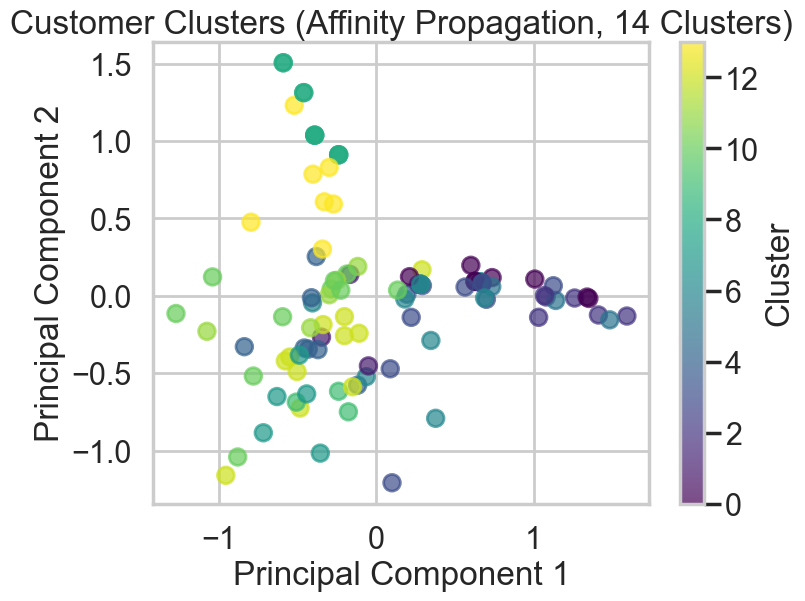


Spectral Clustering: Number of Clusters = 3
Spectral Clustering Silhouette Score: 0.106


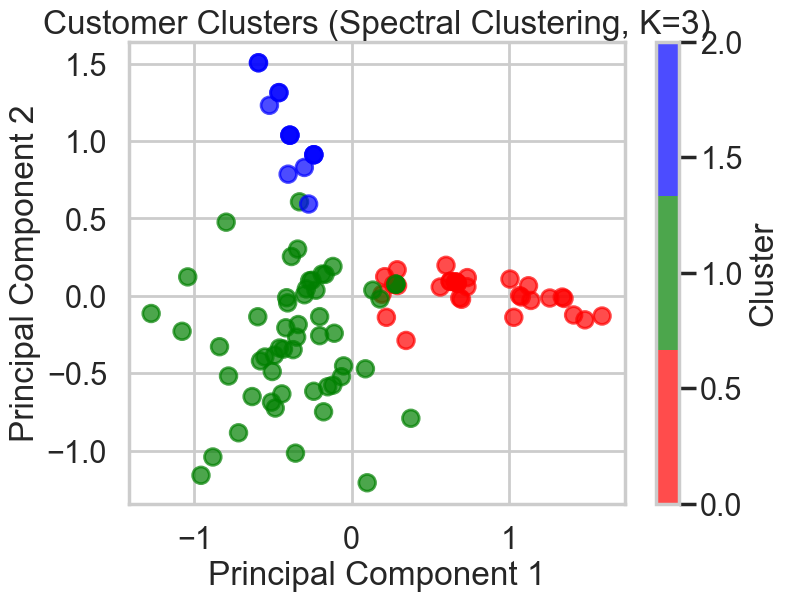


Agglomerative Clustering: Number of Clusters = 3
Agglomerative Clustering Silhouette Score: 0.116


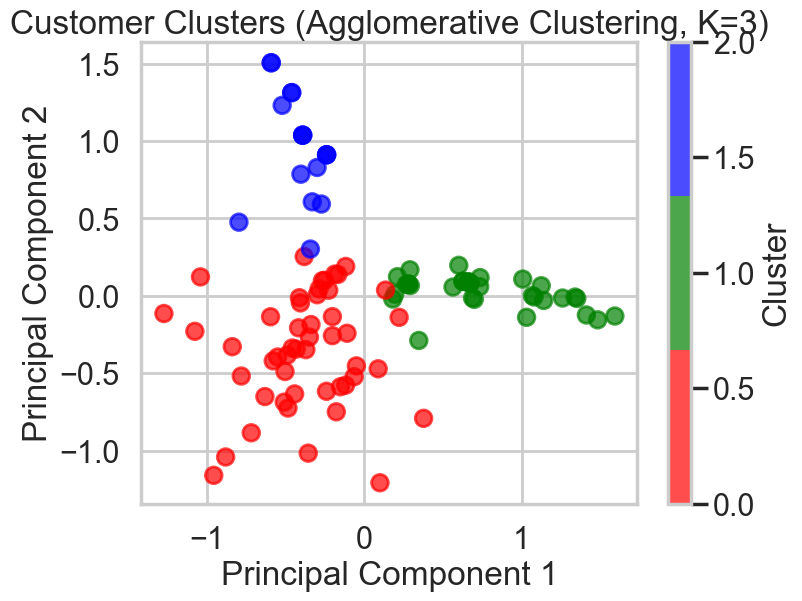


DBSCAN: Number of Clusters = 1, Noise Points = 3
DBSCAN: Silhouette score not applicable (too few clusters or too much noise).


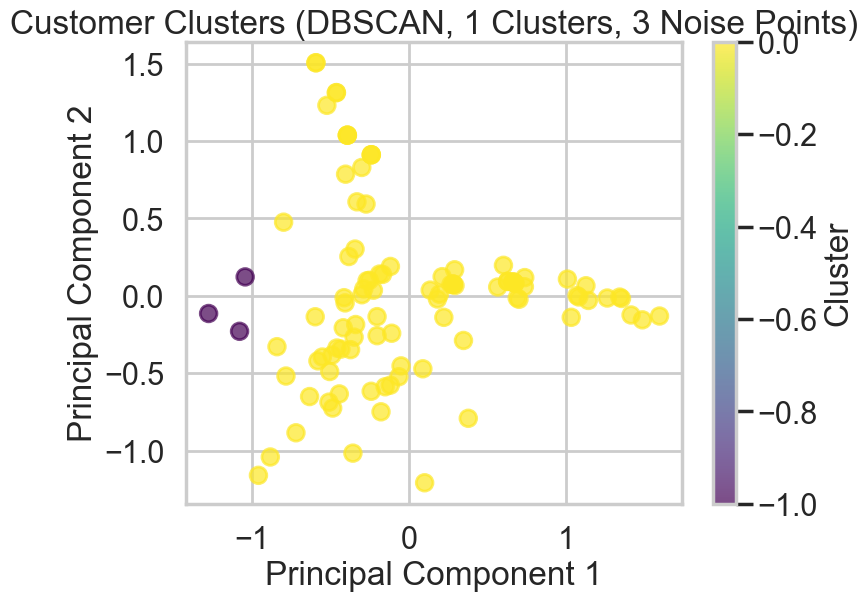

In [31]:
# Your turn (Consolidated all the code for easier review of the outputs)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import sklearn.cluster
import sklearn.metrics
import sklearn.decomposition

# Load and prepare data
df_offers = pd.read_excel("WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_transactions = pd.read_excel("WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
merged = pd.merge(df_transactions, df_offers)
pivoted = merged.pivot_table(index='customer_name', columns='offer_id', values='n', fill_value=0)
pivoted = pivoted.reindex(columns=range(1, 33), fill_value=0)

# Initialize data structures
ss = []  # Sum of Squares
assignments = {}
X = pivoted.to_numpy()
Krange = list(range(2, 11))

# Elbow method
for K in Krange:
    model = sklearn.cluster.KMeans(n_clusters=K, random_state=42)
    assigned_cluster = model.fit_predict(X)
    centers = model.cluster_centers_
    ss.append(np.sum((X - centers[assigned_cluster]) ** 2))
    assignments[str(K)] = assigned_cluster

plt.plot(Krange, ss, marker='o')
plt.xlabel("$K$")
plt.ylabel("Sum of Squares")
plt.title("Elbow Method for Optimal K")
plt.show()

# Silhouette Analysis
avg_silhouette_scores = []
for K in Krange:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 5)
    
    ax1.set_xlim([-0.25, 1])
    ax1.set_ylim([0, len(X) + (K + 1) * 10])
    
    clusterer = sklearn.cluster.KMeans(n_clusters=K, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)
    
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)
    
    y_lower = 10
    for i in range(K):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / K)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % K),
                 fontsize=14, fontweight='bold')
    plt.show()

# Plot average silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(Krange, avg_silhouette_scores, marker='o')
plt.title("Average Silhouette Score vs. Number of Clusters")
plt.xlabel("$K$")
plt.ylabel("Average Silhouette Score")
plt.grid(True)
plt.show()

# Print silhouette scores
print("Average Silhouette Scores:")
for K, score in zip(Krange, avg_silhouette_scores):
    print(f"K={K}: {score:.3f}")

# Gap Statistic
def compute_gap_statistic(X, k_max=10, n_refs=10):
    gaps = []
    stds = []
    k_range = range(1, k_max + 1)
    
    for k in k_range:
        kmeans = sklearn.cluster.KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        log_wcss = np.log(kmeans.inertia_) if kmeans.inertia_ > 0 else 0
        
        ref_wcss = []
        for _ in range(n_refs):
            ref_data = np.random.randint(0, 2, size=X.shape)
            kmeans_ref = sklearn.cluster.KMeans(n_clusters=k, random_state=42)
            kmeans_ref.fit(ref_data)
            ref_wcss.append(np.log(kmeans_ref.inertia_) if kmeans_ref.inertia_ > 0 else 0)
        
        ref_mean = np.mean(ref_wcss)
        gap = ref_mean - log_wcss
        sigma_ss = np.std(ref_wcss)
        s_k = np.sqrt(1 + 1/n_refs) * sigma_ss
        
        gaps.append(gap)
        stds.append(s_k)
    
    return gaps, stds

# Compute Gap statistic
gaps, stds = compute_gap_statistic(X, k_max=10, n_refs=10)

# Choose K using the criterion
optimal_k = None
for k in range(len(gaps) - 1):
    if gaps[k] >= gaps[k + 1] - stds[k + 1]:
        optimal_k = k + 1
        break
if optimal_k is None:
    optimal_k = np.argmax(gaps) + 1

# Plot Gap statistic
plt.figure(figsize=(8, 5))
plt.errorbar(range(1, 11), gaps, yerr=stds, fmt='o-', capsize=5)
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal K = {optimal_k}')
plt.title("Gap Statistic vs. Number of Clusters")
plt.xlabel("$K$")
plt.ylabel("Gap Statistic")
plt.legend()
plt.grid(True)
plt.show()

# Print Gap statistic results
print("Gap Statistic Results:")
for k, gap, std in zip(range(1, 11), gaps, stds):
    print(f"K={k}: Gap={gap:.3f}, Std={std:.3f}")
print(f"Optimal K from Gap Statistic: {optimal_k}")

# Final Clustering with K=3 (K-Means)
model = sklearn.cluster.KMeans(n_clusters=3)
cluster_assignments = model.fit_predict(X)

# PCA Analysis for Visualization (K-Means)
cmap = matplotlib.colors.ListedColormap(['red', 'green', 'blue'])
pca = sklearn.decomposition.PCA(n_components=2)
pc1, pc2 = zip(*pca.fit_transform(X))

# Create DataFrame with customer_name, cluster, x, y
pca_df = pd.DataFrame({
    'customer_name': pivoted.index,
    'cluster': cluster_assignments,
    'x': pc1,
    'y': pc2
})

# Plot scatterplot (K-Means)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pc1, pc2, c=cluster_assignments.tolist(), cmap=cmap, alpha=0.7)
plt.title("Customer Clusters (K-Means, K=3)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

# Print explained variance ratio for 2D PCA
print("\nExplained Variance Ratio (PC1, PC2):", pca.explained_variance_ratio_)
print("Total Variance Explained (2D):", sum(pca.explained_variance_ratio_))

# Silhouette Score for K-Means
kmeans_silhouette = sklearn.metrics.silhouette_score(X, cluster_assignments)
print(f"K-Means Silhouette Score (K=3): {kmeans_silhouette:.3f}")

# Analyze the clusters (K-Means)
customer_clusters = pd.DataFrame({
    'customer_name': pivoted.index,
    'cluster': cluster_assignments
})

# Compute cluster profiles
cluster_profiles = pivoted.copy()
cluster_profiles['cluster'] = cluster_assignments
cluster_profiles = cluster_profiles.groupby('cluster').mean()

# Merge with df_offers
cluster_profiles = cluster_profiles.T.reset_index().rename(columns={'index': 'offer_id'})
cluster_profiles = cluster_profiles.merge(df_offers, on='offer_id', how='left')

# Cluster Analysis: Sort and analyze top offers per cluster (K-Means)
print("\nTop Offers for Cluster 0 (K-Means):")
top_cluster_0 = cluster_profiles.sort_values(0, ascending=False).head(5)
print(top_cluster_0[['offer_id', 'varietal', 'discount', 'origin', 'past_peak', 0]])

print("\nTop Offers for Cluster 1 (K-Means):")
top_cluster_1 = cluster_profiles.sort_values(1, ascending=False).head(5)
print(top_cluster_1[['offer_id', 'varietal', 'discount', 'origin', 'past_peak', 1]])

print("\nTop Offers for Cluster 2 (K-Means):")
top_cluster_2 = cluster_profiles.sort_values(2, ascending=False).head(5)
print(top_cluster_2[['offer_id', 'varietal', 'discount', 'origin', 'past_peak', 2]])

# Compare with Other Clustering Algorithms

# Affinity Propagation
affinity = sklearn.cluster.AffinityPropagation(random_state=42)
affinity_labels = affinity.fit_predict(X)
n_clusters_affinity = len(np.unique(affinity_labels))
print(f"\nAffinity Propagation: Number of Clusters = {n_clusters_affinity}")

# Silhouette Score for Affinity Propagation
if n_clusters_affinity > 1:
    affinity_silhouette = sklearn.metrics.silhouette_score(X, affinity_labels)
    print(f"Affinity Propagation Silhouette Score: {affinity_silhouette:.3f}")
else:
    print("Affinity Propagation: Silhouette score not applicable (1 cluster or noise).")

# Plot Affinity Propagation
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pc1, pc2, c=affinity_labels, cmap='viridis', alpha=0.7)
plt.title(f"Customer Clusters (Affinity Propagation, {n_clusters_affinity} Clusters)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

# Spectral Clustering
spectral = sklearn.cluster.SpectralClustering(n_clusters=3, random_state=42, affinity='rbf')
spectral_labels = spectral.fit_predict(X)
print(f"\nSpectral Clustering: Number of Clusters = 3")

# Silhouette Score for Spectral Clustering
spectral_silhouette = sklearn.metrics.silhouette_score(X, spectral_labels)
print(f"Spectral Clustering Silhouette Score: {spectral_silhouette:.3f}")

# Plot Spectral Clustering
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pc1, pc2, c=spectral_labels, cmap=cmap, alpha=0.7)
plt.title("Customer Clusters (Spectral Clustering, K=3)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

# Agglomerative Clustering
agglomerative = sklearn.cluster.AgglomerativeClustering(n_clusters=3, linkage='ward')
agglomerative_labels = agglomerative.fit_predict(X)
print(f"\nAgglomerative Clustering: Number of Clusters = 3")

# Silhouette Score for Agglomerative Clustering
agglomerative_silhouette = sklearn.metrics.silhouette_score(X, agglomerative_labels)
print(f"Agglomerative Clustering Silhouette Score: {agglomerative_silhouette:.3f}")

# Plot Agglomerative Clustering
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pc1, pc2, c=agglomerative_labels, cmap=cmap, alpha=0.7)
plt.title("Customer Clusters (Agglomerative Clustering, K=3)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

# DBSCAN
dbscan = sklearn.cluster.DBSCAN(eps=2.0, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)
n_clusters_dbscan = len(np.unique(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)  # Exclude noise (-1)
n_noise = list(dbscan_labels).count(-1)
print(f"\nDBSCAN: Number of Clusters = {n_clusters_dbscan}, Noise Points = {n_noise}")

# Silhouette Score for DBSCAN (excluding noise points)
if n_clusters_dbscan > 1 and n_noise < len(X):
    dbscan_silhouette = sklearn.metrics.silhouette_score(X[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
    print(f"DBSCAN Silhouette Score (excluding noise): {dbscan_silhouette:.3f}")
else:
    print("DBSCAN: Silhouette score not applicable (too few clusters or too much noise).")

# Plot DBSCAN
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pc1, pc2, c=dbscan_labels, cmap='viridis', alpha=0.7)
plt.title(f"Customer Clusters (DBSCAN, {n_clusters_dbscan} Clusters, {n_noise} Noise Points)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

# Save results
customer_clusters.to_csv('customer_clusters.csv', index=False)
cluster_profiles.to_csv('cluster_profiles.csv', index=False)
pca_df.to_csv('pca_clusters.csv', index=False)

### Story: Agglomerative Clustering Performs the Best


Best-Performing Algorithm
Agglomerative Clustering:
Silhouette Score: 0.116 (second highest, after Affinity Propagation).
Number of Clusters: 3 (practical and interpretable).
Performance: Slightly outperforms K-Means (0.116 vs. 0.111), with tighter clusters due to ‘ward’ linkage minimizing variance.
Interpretability: Matches K-Means’ practical segmentation (3 clusters for ~100 customers), likely forming similar groups (celebration enthusiasts, deal seekers, Pinot Noir aficionados).
Comparison:
Affinity Propagation (0.129) has the highest silhouette score but over-clusters (14 clusters), reducing interpretability for customer segmentation.
Spectral Clustering (0.106) performs worse than K-Means, likely due to the RBF kernel struggling with sparse data.
DBSCAN fails entirely, as expected for sparse data with varying density.



Agglomerative Clustering outperforms the other algorithms for this sparse, binary dataset because its hierarchical approach with ‘ward’ linkage effectively captures the underlying structure while maintaining practical interpretability. The dataset (~100 customers, 32 binary features, ~324 non-zero entries) is sparse, with customers forming loose, overlapping groups based on their purchasing patterns (e.g., sparkling wines for celebrations, reds for regular consumption, deal-driven variety). Agglomerative Clustering starts by treating each customer as a cluster and iteratively merges the closest pairs, using ‘ward’ linkage to minimize within-cluster variance. This method adapts to the sparse data’s varying density, forming three cohesive clusters that align with meaningful customer segments: celebration enthusiasts, eclectic deal seekers, and Pinot Noir aficionados. Its silhouette score (0.116) reflects this improved cohesion compared to K-Means (0.111) and Spectral Clustering (0.106), which assume spherical or non-linear clusters that don’t fully fit the data’s structure. Affinity Propagation (0.129) over-clusters with 14 groups, capturing noise and minor variations, making it impractical for customer segmentation with only ~100 customers. DBSCAN fails due to the data’s sparsity, as most points are too far apart to form dense clusters, resulting in just one cluster and noise. Agglomerative Clustering strikes a balance, leveraging the hierarchical merging to form interpretable, cohesive clusters that reflect the data’s true purchasing patterns, making it the best performer for this task.